# This is a tutorial of using spaLDVAE for detecting spatial and non-spatial genes in the human DLPFC section 151673 data

This tutorial was implemented on Macbook Pro M1.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaLDVAE import SPALDVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'sample_151673.h5'
        self.select_genes = 0
        self.batch_size = 512
        self.maxiter = 2000
        self.lr = 1e-3
        self.weight_decay = 1e-2
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64, 32]
        self.z_dim = 5
        self.decoder_layers = [32]
        self.beta = 1
        self.num_samples = 1
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 6
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.loc_range = 20.
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.spatial_score_file = "spatial_score.txt"
        self.device = "cpu"

args = Args()
     

Setup inducing points, preprocess count matrix, and build the spaLDVAE model.

In [3]:
print(args)

data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64') # count matrix
loc = np.array(data_mat['pos']).astype('float64') # location information
gene_name = np.array(data_mat['gene']).astype('U26') # gene names
data_mat.close()

if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]
    gene_name = gene_name[importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * args.loc_range

print(x.shape)
print(loc.shape)

# We provide two ways to generate inducing point, argument "grid_inducing_points" controls whether to choice grid inducing or k-means
# One way is grid inducing points, argument "inducing_point_steps" controls number of grid steps, the resulting number of inducing point is (inducing_point_steps+1)^2
# Another way is k-means on the locations, argument "inducing_point_nums" controls number of inducing points
if args.grid_inducing_points:
    eps = 1e-5
    initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * args.loc_range
    print(initial_inducing_points.shape)
else:
    loc_kmeans = KMeans(n_clusters=args.inducing_point_nums, n_init=100).fit(loc)
    np.savetxt("location_centroids.txt", loc_kmeans.cluster_centers_, delimiter=",")
    np.savetxt("location_kmeans_labels.txt", loc_kmeans.labels_, delimiter=",", fmt="%i")
    initial_inducing_points = loc_kmeans.cluster_centers_

adata = sc.AnnData(x, dtype="float64")

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPALDVAE(input_dim=adata.n_vars, z_dim=args.z_dim, encoder_layers=args.encoder_layers, encoder_dropout=args.dropoutE,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata.n_obs, beta=args.beta, dtype=torch.float64, 
    device=args.device)

print(str(model))

(3639, 4000)
(3639, 2)
(49, 2)
SPALDVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=4000, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=32, out_features=10, bias=True)
    (enc_var): Linear(in_features=32, out_features=10, bias=True)
  )
  (NB_loss): NBLoss()
)


Train the model.

In [4]:
t0 = time()

model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            maxiter=args.maxiter, save_model=True, model_weights=args.model_file)
print('Training time: %d seconds.' % int(time() - t0))

spatial_score = model.spatial_score(gene_name=gene_name)
spatial_score.to_csv(args.spatial_score_file)

#print head 10 lines of spatial score matrix
print(spatial_score[:10])

Training
Training epoch 1, ELBO:3.12560042, NB loss:2.99145154, GP KLD loss:0.01409950, Gaussian KLD loss:0.12004938,
Current kernel scale tensor([20.0056])
Training epoch 2, ELBO:2.92064379, NB loss:2.85248947, GP KLD loss:0.01384928, Gaussian KLD loss:0.05430505,
Current kernel scale tensor([20.0112])
Training epoch 3, ELBO:2.80389828, NB loss:2.75034647, GP KLD loss:0.01408086, Gaussian KLD loss:0.03947095,
Current kernel scale tensor([20.0165])
Training epoch 4, ELBO:2.71155973, NB loss:2.65589409, GP KLD loss:0.01514414, Gaussian KLD loss:0.04052149,
Current kernel scale tensor([20.0219])
Training epoch 5, ELBO:2.60736066, NB loss:2.54209388, GP KLD loss:0.01676057, Gaussian KLD loss:0.04850621,
Current kernel scale tensor([20.0273])
Training epoch 6, ELBO:2.50312867, NB loss:2.42506652, GP KLD loss:0.01931758, Gaussian KLD loss:0.05874457,
Current kernel scale tensor([20.0323])
Training epoch 7, ELBO:2.39913760, NB loss:2.30613475, GP KLD loss:0.02180127, Gaussian KLD loss:0.0712

Training epoch 56, ELBO:1.58207884, NB loss:1.33790917, GP KLD loss:0.03442950, Gaussian KLD loss:0.20974018,
Current kernel scale tensor([20.1270])
Training epoch 57, ELBO:1.57590200, NB loss:1.33444230, GP KLD loss:0.03371114, Gaussian KLD loss:0.20774855,
Current kernel scale tensor([20.1321])
Training epoch 58, ELBO:1.56670079, NB loss:1.32492725, GP KLD loss:0.03351892, Gaussian KLD loss:0.20825462,
Current kernel scale tensor([20.1372])
Training epoch 59, ELBO:1.56809511, NB loss:1.32651127, GP KLD loss:0.03436476, Gaussian KLD loss:0.20721907,
Current kernel scale tensor([20.1425])
Training epoch 60, ELBO:1.55541145, NB loss:1.31675400, GP KLD loss:0.03290937, Gaussian KLD loss:0.20574808,
Current kernel scale tensor([20.1477])
Training epoch 61, ELBO:1.55727173, NB loss:1.32054174, GP KLD loss:0.03284640, Gaussian KLD loss:0.20388359,
Current kernel scale tensor([20.1530])
Training epoch 62, ELBO:1.54278614, NB loss:1.30805830, GP KLD loss:0.03236302, Gaussian KLD loss:0.202364

Training epoch 111, ELBO:1.30755421, NB loss:1.14433634, GP KLD loss:0.02562153, Gaussian KLD loss:0.13759634,
Current kernel scale tensor([20.4461])
Training epoch 112, ELBO:1.30149839, NB loss:1.13879184, GP KLD loss:0.02529557, Gaussian KLD loss:0.13741099,
Current kernel scale tensor([20.4520])
Training epoch 113, ELBO:1.30436742, NB loss:1.14349580, GP KLD loss:0.02517146, Gaussian KLD loss:0.13570016,
Current kernel scale tensor([20.4579])
Training epoch 114, ELBO:1.29481788, NB loss:1.13482283, GP KLD loss:0.02502767, Gaussian KLD loss:0.13496738,
Current kernel scale tensor([20.4638])
Training epoch 115, ELBO:1.28930276, NB loss:1.13073048, GP KLD loss:0.02491062, Gaussian KLD loss:0.13366165,
Current kernel scale tensor([20.4696])
Training epoch 116, ELBO:1.27962137, NB loss:1.12294816, GP KLD loss:0.02491537, Gaussian KLD loss:0.13175784,
Current kernel scale tensor([20.4755])
Training epoch 117, ELBO:1.28541968, NB loss:1.13102305, GP KLD loss:0.02459344, Gaussian KLD loss:0

Training epoch 166, ELBO:1.11552642, NB loss:1.00630674, GP KLD loss:0.01952126, Gaussian KLD loss:0.08969841,
Current kernel scale tensor([20.7532])
Training epoch 167, ELBO:1.11030684, NB loss:1.00174746, GP KLD loss:0.01948158, Gaussian KLD loss:0.08907779,
Current kernel scale tensor([20.7585])
Training epoch 168, ELBO:1.10794218, NB loss:1.00098199, GP KLD loss:0.01943300, Gaussian KLD loss:0.08752719,
Current kernel scale tensor([20.7637])
Training epoch 169, ELBO:1.10268277, NB loss:0.99645479, GP KLD loss:0.01937297, Gaussian KLD loss:0.08685500,
Current kernel scale tensor([20.7690])
Training epoch 170, ELBO:1.09938886, NB loss:0.99447272, GP KLD loss:0.01910401, Gaussian KLD loss:0.08581213,
Current kernel scale tensor([20.7743])
Training epoch 171, ELBO:1.10042598, NB loss:0.99659881, GP KLD loss:0.01905420, Gaussian KLD loss:0.08477297,
Current kernel scale tensor([20.7795])
Training epoch 172, ELBO:1.09609928, NB loss:0.99284392, GP KLD loss:0.01903007, Gaussian KLD loss:0

Training epoch 221, ELBO:0.97561715, NB loss:0.90177602, GP KLD loss:0.01632957, Gaussian KLD loss:0.05751156,
Current kernel scale tensor([21.0325])
Training epoch 222, ELBO:0.97352457, NB loss:0.89936272, GP KLD loss:0.01627518, Gaussian KLD loss:0.05788667,
Current kernel scale tensor([21.0374])
Training epoch 223, ELBO:0.96845555, NB loss:0.89477286, GP KLD loss:0.01614791, Gaussian KLD loss:0.05753478,
Current kernel scale tensor([21.0423])
Training epoch 224, ELBO:0.96524711, NB loss:0.89298480, GP KLD loss:0.01613320, Gaussian KLD loss:0.05612911,
Current kernel scale tensor([21.0472])
Training epoch 225, ELBO:0.96244981, NB loss:0.89126578, GP KLD loss:0.01617193, Gaussian KLD loss:0.05501210,
Current kernel scale tensor([21.0520])
Training epoch 226, ELBO:0.96735118, NB loss:0.89618857, GP KLD loss:0.01613799, Gaussian KLD loss:0.05502462,
Current kernel scale tensor([21.0569])
Training epoch 227, ELBO:0.95923890, NB loss:0.88731797, GP KLD loss:0.01620134, Gaussian KLD loss:0

Training epoch 276, ELBO:0.87278788, NB loss:0.82036605, GP KLD loss:0.01503233, Gaussian KLD loss:0.03738949,
Current kernel scale tensor([21.2979])
Training epoch 277, ELBO:0.87654732, NB loss:0.82384114, GP KLD loss:0.01495520, Gaussian KLD loss:0.03775098,
Current kernel scale tensor([21.3026])
Training epoch 278, ELBO:0.87103333, NB loss:0.81741200, GP KLD loss:0.01484559, Gaussian KLD loss:0.03877575,
Current kernel scale tensor([21.3074])
Training epoch 279, ELBO:0.86480875, NB loss:0.81185592, GP KLD loss:0.01475659, Gaussian KLD loss:0.03819624,
Current kernel scale tensor([21.3122])
Training epoch 280, ELBO:0.86608177, NB loss:0.81535816, GP KLD loss:0.01473596, Gaussian KLD loss:0.03598765,
Current kernel scale tensor([21.3169])
Training epoch 281, ELBO:0.86746436, NB loss:0.81690081, GP KLD loss:0.01475040, Gaussian KLD loss:0.03581316,
Current kernel scale tensor([21.3217])
Training epoch 282, ELBO:0.86549134, NB loss:0.81380545, GP KLD loss:0.01480004, Gaussian KLD loss:0

Training epoch 331, ELBO:0.80064116, NB loss:0.76055372, GP KLD loss:0.01409097, Gaussian KLD loss:0.02599646,
Current kernel scale tensor([21.5570])
Training epoch 332, ELBO:0.79978226, NB loss:0.76033503, GP KLD loss:0.01396623, Gaussian KLD loss:0.02548100,
Current kernel scale tensor([21.5617])
Training epoch 333, ELBO:0.79626081, NB loss:0.75670930, GP KLD loss:0.01394995, Gaussian KLD loss:0.02560156,
Current kernel scale tensor([21.5663])
Training epoch 334, ELBO:0.79383749, NB loss:0.75488489, GP KLD loss:0.01391049, Gaussian KLD loss:0.02504211,
Current kernel scale tensor([21.5710])
Training epoch 335, ELBO:0.79599484, NB loss:0.75783901, GP KLD loss:0.01397278, Gaussian KLD loss:0.02418304,
Current kernel scale tensor([21.5757])
Training epoch 336, ELBO:0.79234000, NB loss:0.75376041, GP KLD loss:0.01399150, Gaussian KLD loss:0.02458809,
Current kernel scale tensor([21.5804])
Training epoch 337, ELBO:0.79485630, NB loss:0.75589017, GP KLD loss:0.01387539, Gaussian KLD loss:0

Training epoch 386, ELBO:0.74326373, NB loss:0.71251843, GP KLD loss:0.01311482, Gaussian KLD loss:0.01763049,
Current kernel scale tensor([21.8100])
Training epoch 387, ELBO:0.74398056, NB loss:0.71313063, GP KLD loss:0.01325898, Gaussian KLD loss:0.01759095,
Current kernel scale tensor([21.8146])
Training epoch 388, ELBO:0.74179472, NB loss:0.71095394, GP KLD loss:0.01327038, Gaussian KLD loss:0.01757040,
Current kernel scale tensor([21.8191])
Training epoch 389, ELBO:0.74149538, NB loss:0.71127308, GP KLD loss:0.01308938, Gaussian KLD loss:0.01713292,
Current kernel scale tensor([21.8237])
Training epoch 390, ELBO:0.73848196, NB loss:0.70817595, GP KLD loss:0.01300764, Gaussian KLD loss:0.01729837,
Current kernel scale tensor([21.8282])
Training epoch 391, ELBO:0.73832321, NB loss:0.70837607, GP KLD loss:0.01306165, Gaussian KLD loss:0.01688549,
Current kernel scale tensor([21.8327])
Training epoch 392, ELBO:0.73920943, NB loss:0.70910519, GP KLD loss:0.01304725, Gaussian KLD loss:0

Training epoch 441, ELBO:0.70113107, NB loss:0.67676173, GP KLD loss:0.01230699, Gaussian KLD loss:0.01206235,
Current kernel scale tensor([22.0565])
Training epoch 442, ELBO:0.69909434, NB loss:0.67451157, GP KLD loss:0.01234853, Gaussian KLD loss:0.01223424,
Current kernel scale tensor([22.0609])
Training epoch 443, ELBO:0.70067910, NB loss:0.67631722, GP KLD loss:0.01224078, Gaussian KLD loss:0.01212109,
Current kernel scale tensor([22.0653])
Training epoch 444, ELBO:0.70081555, NB loss:0.67617572, GP KLD loss:0.01216279, Gaussian KLD loss:0.01247704,
Current kernel scale tensor([22.0697])
Training epoch 445, ELBO:0.69849126, NB loss:0.67379530, GP KLD loss:0.01233091, Gaussian KLD loss:0.01236505,
Current kernel scale tensor([22.0741])
Training epoch 446, ELBO:0.69724987, NB loss:0.67318550, GP KLD loss:0.01229114, Gaussian KLD loss:0.01177323,
Current kernel scale tensor([22.0785])
Training epoch 447, ELBO:0.69874681, NB loss:0.67493672, GP KLD loss:0.01226619, Gaussian KLD loss:0

Training epoch 496, ELBO:0.66808363, NB loss:0.64797424, GP KLD loss:0.01136196, Gaussian KLD loss:0.00874743,
Current kernel scale tensor([22.2942])
Training epoch 497, ELBO:0.66801905, NB loss:0.64808576, GP KLD loss:0.01131132, Gaussian KLD loss:0.00862197,
Current kernel scale tensor([22.2984])
Training epoch 498, ELBO:0.66673531, NB loss:0.64663418, GP KLD loss:0.01131000, Gaussian KLD loss:0.00879112,
Current kernel scale tensor([22.3026])
Training epoch 499, ELBO:0.66777641, NB loss:0.64780050, GP KLD loss:0.01136504, Gaussian KLD loss:0.00861087,
Current kernel scale tensor([22.3068])
Training epoch 500, ELBO:0.66637023, NB loss:0.64662364, GP KLD loss:0.01129708, Gaussian KLD loss:0.00844951,
Current kernel scale tensor([22.3110])
Training epoch 501, ELBO:0.66527585, NB loss:0.64522738, GP KLD loss:0.01126513, Gaussian KLD loss:0.00878334,
Current kernel scale tensor([22.3152])
Training epoch 502, ELBO:0.66390527, NB loss:0.64389998, GP KLD loss:0.01130586, Gaussian KLD loss:0

Training epoch 551, ELBO:0.64121541, NB loss:0.62460640, GP KLD loss:0.01037551, Gaussian KLD loss:0.00623350,
Current kernel scale tensor([22.5217])
Training epoch 552, ELBO:0.64101437, NB loss:0.62439837, GP KLD loss:0.01047364, Gaussian KLD loss:0.00614236,
Current kernel scale tensor([22.5257])
Training epoch 553, ELBO:0.64183683, NB loss:0.62502914, GP KLD loss:0.01037892, Gaussian KLD loss:0.00642877,
Current kernel scale tensor([22.5298])
Training epoch 554, ELBO:0.63962547, NB loss:0.62262813, GP KLD loss:0.01042660, Gaussian KLD loss:0.00657074,
Current kernel scale tensor([22.5339])
Training epoch 555, ELBO:0.64182735, NB loss:0.62525426, GP KLD loss:0.01038203, Gaussian KLD loss:0.00619106,
Current kernel scale tensor([22.5379])
Training epoch 556, ELBO:0.64026806, NB loss:0.62354951, GP KLD loss:0.01027775, Gaussian KLD loss:0.00644080,
Current kernel scale tensor([22.5420])
Training epoch 557, ELBO:0.63892033, NB loss:0.62217206, GP KLD loss:0.01028341, Gaussian KLD loss:0

Training epoch 606, ELBO:0.62079007, NB loss:0.60651196, GP KLD loss:0.00965502, Gaussian KLD loss:0.00462309,
Current kernel scale tensor([22.7411])
Training epoch 607, ELBO:0.62045872, NB loss:0.60584449, GP KLD loss:0.00957321, Gaussian KLD loss:0.00504102,
Current kernel scale tensor([22.7450])
Training epoch 608, ELBO:0.61832624, NB loss:0.60423009, GP KLD loss:0.00934053, Gaussian KLD loss:0.00475562,
Current kernel scale tensor([22.7489])
Training epoch 609, ELBO:0.61814485, NB loss:0.60408167, GP KLD loss:0.00959370, Gaussian KLD loss:0.00446948,
Current kernel scale tensor([22.7529])
Training epoch 610, ELBO:0.61971755, NB loss:0.60571977, GP KLD loss:0.00954551, Gaussian KLD loss:0.00445226,
Current kernel scale tensor([22.7568])
Training epoch 611, ELBO:0.61805762, NB loss:0.60375502, GP KLD loss:0.00942152, Gaussian KLD loss:0.00488108,
Current kernel scale tensor([22.7607])
Training epoch 612, ELBO:0.61784617, NB loss:0.60365779, GP KLD loss:0.00944954, Gaussian KLD loss:0

Training epoch 661, ELBO:0.60254754, NB loss:0.59025119, GP KLD loss:0.00884268, Gaussian KLD loss:0.00345367,
Current kernel scale tensor([22.9577])
Training epoch 662, ELBO:0.60108868, NB loss:0.58834744, GP KLD loss:0.00902631, Gaussian KLD loss:0.00371494,
Current kernel scale tensor([22.9617])
Training epoch 663, ELBO:0.60065534, NB loss:0.58830378, GP KLD loss:0.00898627, Gaussian KLD loss:0.00336529,
Current kernel scale tensor([22.9657])
Training epoch 664, ELBO:0.60040820, NB loss:0.58802770, GP KLD loss:0.00902540, Gaussian KLD loss:0.00335510,
Current kernel scale tensor([22.9697])
Training epoch 665, ELBO:0.60058127, NB loss:0.58810421, GP KLD loss:0.00900506, Gaussian KLD loss:0.00347200,
Current kernel scale tensor([22.9738])
Training epoch 666, ELBO:0.60098173, NB loss:0.58833593, GP KLD loss:0.00909538, Gaussian KLD loss:0.00355042,
Current kernel scale tensor([22.9778])
Training epoch 667, ELBO:0.59943833, NB loss:0.58688243, GP KLD loss:0.00903523, Gaussian KLD loss:0

Training epoch 716, ELBO:0.58576191, NB loss:0.57382884, GP KLD loss:0.00912963, Gaussian KLD loss:0.00280343,
Current kernel scale tensor([23.1904])
Training epoch 717, ELBO:0.58575815, NB loss:0.57395941, GP KLD loss:0.00912132, Gaussian KLD loss:0.00267742,
Current kernel scale tensor([23.1949])
Training epoch 718, ELBO:0.58467942, NB loss:0.57268129, GP KLD loss:0.00921018, Gaussian KLD loss:0.00278795,
Current kernel scale tensor([23.1994])
Training epoch 719, ELBO:0.58550969, NB loss:0.57368074, GP KLD loss:0.00904324, Gaussian KLD loss:0.00278572,
Current kernel scale tensor([23.2038])
Training epoch 720, ELBO:0.58506696, NB loss:0.57330987, GP KLD loss:0.00905363, Gaussian KLD loss:0.00270346,
Current kernel scale tensor([23.2084])
Training epoch 721, ELBO:0.58393033, NB loss:0.57193675, GP KLD loss:0.00921490, Gaussian KLD loss:0.00277868,
Current kernel scale tensor([23.2129])
Training epoch 722, ELBO:0.58374460, NB loss:0.57183094, GP KLD loss:0.00928810, Gaussian KLD loss:0

Training epoch 771, ELBO:0.57067356, NB loss:0.55941237, GP KLD loss:0.00905104, Gaussian KLD loss:0.00221014,
Current kernel scale tensor([23.4472])
Training epoch 772, ELBO:0.57146627, NB loss:0.56031550, GP KLD loss:0.00909404, Gaussian KLD loss:0.00205673,
Current kernel scale tensor([23.4521])
Training epoch 773, ELBO:0.57123498, NB loss:0.56003591, GP KLD loss:0.00909064, Gaussian KLD loss:0.00210842,
Current kernel scale tensor([23.4569])
Training epoch 774, ELBO:0.57094733, NB loss:0.55972907, GP KLD loss:0.00914556, Gaussian KLD loss:0.00207270,
Current kernel scale tensor([23.4618])
Training epoch 775, ELBO:0.56997924, NB loss:0.55881571, GP KLD loss:0.00918879, Gaussian KLD loss:0.00197474,
Current kernel scale tensor([23.4668])
Training epoch 776, ELBO:0.56959552, NB loss:0.55846022, GP KLD loss:0.00910493, Gaussian KLD loss:0.00203037,
Current kernel scale tensor([23.4716])
Training epoch 777, ELBO:0.56912142, NB loss:0.55800854, GP KLD loss:0.00908295, Gaussian KLD loss:0

Training epoch 826, ELBO:0.56012189, NB loss:0.54969489, GP KLD loss:0.00886212, Gaussian KLD loss:0.00156488,
Current kernel scale tensor([23.7207])
Training epoch 827, ELBO:0.55988162, NB loss:0.54922837, GP KLD loss:0.00899811, Gaussian KLD loss:0.00165514,
Current kernel scale tensor([23.7258])
Training epoch 828, ELBO:0.55838957, NB loss:0.54805325, GP KLD loss:0.00881183, Gaussian KLD loss:0.00152449,
Current kernel scale tensor([23.7308])
Training epoch 829, ELBO:0.55762833, NB loss:0.54724206, GP KLD loss:0.00891900, Gaussian KLD loss:0.00146727,
Current kernel scale tensor([23.7358])
Training epoch 830, ELBO:0.55928370, NB loss:0.54884245, GP KLD loss:0.00893182, Gaussian KLD loss:0.00150944,
Current kernel scale tensor([23.7408])
Training epoch 831, ELBO:0.55903641, NB loss:0.54864776, GP KLD loss:0.00879321, Gaussian KLD loss:0.00159544,
Current kernel scale tensor([23.7458])
Training epoch 832, ELBO:0.55799772, NB loss:0.54757600, GP KLD loss:0.00889994, Gaussian KLD loss:0

Training epoch 881, ELBO:0.54969036, NB loss:0.54019761, GP KLD loss:0.00839061, Gaussian KLD loss:0.00110213,
Current kernel scale tensor([23.9986])
Training epoch 882, ELBO:0.54901670, NB loss:0.53944042, GP KLD loss:0.00845426, Gaussian KLD loss:0.00112202,
Current kernel scale tensor([24.0037])
Training epoch 883, ELBO:0.54942336, NB loss:0.53976562, GP KLD loss:0.00853454, Gaussian KLD loss:0.00112321,
Current kernel scale tensor([24.0087])
Training epoch 884, ELBO:0.54999535, NB loss:0.54018184, GP KLD loss:0.00859097, Gaussian KLD loss:0.00122254,
Current kernel scale tensor([24.0137])
Training epoch 885, ELBO:0.54909456, NB loss:0.53942570, GP KLD loss:0.00850070, Gaussian KLD loss:0.00116816,
Current kernel scale tensor([24.0188])
Training epoch 886, ELBO:0.54861091, NB loss:0.53912329, GP KLD loss:0.00844925, Gaussian KLD loss:0.00103837,
Current kernel scale tensor([24.0238])
Training epoch 887, ELBO:0.54898475, NB loss:0.53940088, GP KLD loss:0.00847401, Gaussian KLD loss:0

Training epoch 936, ELBO:0.54189303, NB loss:0.53283310, GP KLD loss:0.00813977, Gaussian KLD loss:0.00092015,
Current kernel scale tensor([24.2737])
Training epoch 937, ELBO:0.54255557, NB loss:0.53366226, GP KLD loss:0.00800388, Gaussian KLD loss:0.00088943,
Current kernel scale tensor([24.2787])
Training epoch 938, ELBO:0.54132165, NB loss:0.53252091, GP KLD loss:0.00797465, Gaussian KLD loss:0.00082609,
Current kernel scale tensor([24.2835])
Training epoch 939, ELBO:0.54170126, NB loss:0.53273247, GP KLD loss:0.00811696, Gaussian KLD loss:0.00085182,
Current kernel scale tensor([24.2884])
Training epoch 940, ELBO:0.54115629, NB loss:0.53235882, GP KLD loss:0.00793135, Gaussian KLD loss:0.00086612,
Current kernel scale tensor([24.2933])
Training epoch 941, ELBO:0.54190528, NB loss:0.53305474, GP KLD loss:0.00800025, Gaussian KLD loss:0.00085029,
Current kernel scale tensor([24.2982])
Training epoch 942, ELBO:0.54163598, NB loss:0.53281114, GP KLD loss:0.00803988, Gaussian KLD loss:0

Training epoch 991, ELBO:0.53580038, NB loss:0.52741347, GP KLD loss:0.00766007, Gaussian KLD loss:0.00072684,
Current kernel scale tensor([24.5430])
Training epoch 992, ELBO:0.53640408, NB loss:0.52816490, GP KLD loss:0.00759030, Gaussian KLD loss:0.00064887,
Current kernel scale tensor([24.5478])
Training epoch 993, ELBO:0.53607773, NB loss:0.52771661, GP KLD loss:0.00764487, Gaussian KLD loss:0.00071624,
Current kernel scale tensor([24.5526])
Training epoch 994, ELBO:0.53547056, NB loss:0.52720876, GP KLD loss:0.00758297, Gaussian KLD loss:0.00067883,
Current kernel scale tensor([24.5574])
Training epoch 995, ELBO:0.53510192, NB loss:0.52698236, GP KLD loss:0.00754044, Gaussian KLD loss:0.00057911,
Current kernel scale tensor([24.5622])
Training epoch 996, ELBO:0.53541469, NB loss:0.52709567, GP KLD loss:0.00763744, Gaussian KLD loss:0.00068159,
Current kernel scale tensor([24.5671])
Training epoch 997, ELBO:0.53459765, NB loss:0.52628901, GP KLD loss:0.00765612, Gaussian KLD loss:0

Training epoch 1046, ELBO:0.53034353, NB loss:0.52266527, GP KLD loss:0.00722569, Gaussian KLD loss:0.00045256,
Current kernel scale tensor([24.8074])
Training epoch 1047, ELBO:0.52995941, NB loss:0.52235929, GP KLD loss:0.00709484, Gaussian KLD loss:0.00050529,
Current kernel scale tensor([24.8121])
Training epoch 1048, ELBO:0.53030280, NB loss:0.52260536, GP KLD loss:0.00719524, Gaussian KLD loss:0.00050219,
Current kernel scale tensor([24.8168])
Training epoch 1049, ELBO:0.53073105, NB loss:0.52292253, GP KLD loss:0.00728198, Gaussian KLD loss:0.00052654,
Current kernel scale tensor([24.8216])
Training epoch 1050, ELBO:0.53005153, NB loss:0.52234658, GP KLD loss:0.00724155, Gaussian KLD loss:0.00046340,
Current kernel scale tensor([24.8263])
Training epoch 1051, ELBO:0.52997683, NB loss:0.52233509, GP KLD loss:0.00716006, Gaussian KLD loss:0.00048168,
Current kernel scale tensor([24.8311])
Training epoch 1052, ELBO:0.53071962, NB loss:0.52300289, GP KLD loss:0.00720494, Gaussian KLD

Training epoch 1101, ELBO:0.52595298, NB loss:0.51858840, GP KLD loss:0.00695397, Gaussian KLD loss:0.00041061,
Current kernel scale tensor([25.0656])
Training epoch 1102, ELBO:0.52529473, NB loss:0.51817922, GP KLD loss:0.00674082, Gaussian KLD loss:0.00037470,
Current kernel scale tensor([25.0702])
Training epoch 1103, ELBO:0.52586920, NB loss:0.51865704, GP KLD loss:0.00684106, Gaussian KLD loss:0.00037110,
Current kernel scale tensor([25.0749])
Training epoch 1104, ELBO:0.52639000, NB loss:0.51911205, GP KLD loss:0.00690460, Gaussian KLD loss:0.00037335,
Current kernel scale tensor([25.0796])
Training epoch 1105, ELBO:0.52580065, NB loss:0.51863200, GP KLD loss:0.00674435, Gaussian KLD loss:0.00042429,
Current kernel scale tensor([25.0842])
Training epoch 1106, ELBO:0.52565307, NB loss:0.51837291, GP KLD loss:0.00693023, Gaussian KLD loss:0.00034993,
Current kernel scale tensor([25.0889])
Training epoch 1107, ELBO:0.52605765, NB loss:0.51874030, GP KLD loss:0.00692245, Gaussian KLD

Training epoch 1156, ELBO:0.52200399, NB loss:0.51518083, GP KLD loss:0.00652338, Gaussian KLD loss:0.00029978,
Current kernel scale tensor([25.3209])
Training epoch 1157, ELBO:0.52222644, NB loss:0.51539143, GP KLD loss:0.00652561, Gaussian KLD loss:0.00030940,
Current kernel scale tensor([25.3255])
Training epoch 1158, ELBO:0.52239557, NB loss:0.51551405, GP KLD loss:0.00657013, Gaussian KLD loss:0.00031139,
Current kernel scale tensor([25.3302])
Training epoch 1159, ELBO:0.52138204, NB loss:0.51447543, GP KLD loss:0.00659273, Gaussian KLD loss:0.00031388,
Current kernel scale tensor([25.3347])
Training epoch 1160, ELBO:0.52197169, NB loss:0.51516146, GP KLD loss:0.00652828, Gaussian KLD loss:0.00028194,
Current kernel scale tensor([25.3393])
Training epoch 1161, ELBO:0.52199266, NB loss:0.51512814, GP KLD loss:0.00657554, Gaussian KLD loss:0.00028898,
Current kernel scale tensor([25.3439])
Training epoch 1162, ELBO:0.52231382, NB loss:0.51548350, GP KLD loss:0.00651906, Gaussian KLD

Training epoch 1211, ELBO:0.51909809, NB loss:0.51250091, GP KLD loss:0.00636323, Gaussian KLD loss:0.00023396,
Current kernel scale tensor([25.5756])
Training epoch 1212, ELBO:0.51966635, NB loss:0.51314046, GP KLD loss:0.00626434, Gaussian KLD loss:0.00026155,
Current kernel scale tensor([25.5802])
Training epoch 1213, ELBO:0.51842988, NB loss:0.51187304, GP KLD loss:0.00630673, Gaussian KLD loss:0.00025011,
Current kernel scale tensor([25.5848])
Training epoch 1214, ELBO:0.51959202, NB loss:0.51306270, GP KLD loss:0.00633324, Gaussian KLD loss:0.00019609,
Current kernel scale tensor([25.5895])
Training epoch 1215, ELBO:0.51906636, NB loss:0.51256040, GP KLD loss:0.00627340, Gaussian KLD loss:0.00023256,
Current kernel scale tensor([25.5941])
Training epoch 1216, ELBO:0.51921372, NB loss:0.51266480, GP KLD loss:0.00630908, Gaussian KLD loss:0.00023984,
Current kernel scale tensor([25.5987])
Training epoch 1217, ELBO:0.51899146, NB loss:0.51245194, GP KLD loss:0.00630488, Gaussian KLD

Training epoch 1266, ELBO:0.51640060, NB loss:0.51023312, GP KLD loss:0.00598924, Gaussian KLD loss:0.00017824,
Current kernel scale tensor([25.8284])
Training epoch 1267, ELBO:0.51628139, NB loss:0.50998404, GP KLD loss:0.00610729, Gaussian KLD loss:0.00019005,
Current kernel scale tensor([25.8330])
Training epoch 1268, ELBO:0.51607929, NB loss:0.50971837, GP KLD loss:0.00616676, Gaussian KLD loss:0.00019416,
Current kernel scale tensor([25.8375])
Training epoch 1269, ELBO:0.51624227, NB loss:0.50996746, GP KLD loss:0.00609808, Gaussian KLD loss:0.00017673,
Current kernel scale tensor([25.8421])
Training epoch 1270, ELBO:0.51659090, NB loss:0.51041521, GP KLD loss:0.00599097, Gaussian KLD loss:0.00018473,
Current kernel scale tensor([25.8466])
Training epoch 1271, ELBO:0.51599298, NB loss:0.50976795, GP KLD loss:0.00605778, Gaussian KLD loss:0.00016725,
Current kernel scale tensor([25.8512])
Training epoch 1272, ELBO:0.51694802, NB loss:0.51061679, GP KLD loss:0.00617037, Gaussian KLD

Training epoch 1321, ELBO:0.51380861, NB loss:0.50777410, GP KLD loss:0.00586776, Gaussian KLD loss:0.00016675,
Current kernel scale tensor([26.0809])
Training epoch 1322, ELBO:0.51378371, NB loss:0.50781218, GP KLD loss:0.00583958, Gaussian KLD loss:0.00013195,
Current kernel scale tensor([26.0854])
Training epoch 1323, ELBO:0.51337668, NB loss:0.50734812, GP KLD loss:0.00588703, Gaussian KLD loss:0.00014152,
Current kernel scale tensor([26.0900])
Training epoch 1324, ELBO:0.51382280, NB loss:0.50777931, GP KLD loss:0.00590802, Gaussian KLD loss:0.00013547,
Current kernel scale tensor([26.0946])
Training epoch 1325, ELBO:0.51357891, NB loss:0.50747072, GP KLD loss:0.00596108, Gaussian KLD loss:0.00014711,
Current kernel scale tensor([26.0991])
Training epoch 1326, ELBO:0.51420720, NB loss:0.50819471, GP KLD loss:0.00586934, Gaussian KLD loss:0.00014315,
Current kernel scale tensor([26.1037])
Training epoch 1327, ELBO:0.51378305, NB loss:0.50776552, GP KLD loss:0.00587383, Gaussian KLD

Training epoch 1376, ELBO:0.51275859, NB loss:0.50692251, GP KLD loss:0.00571825, Gaussian KLD loss:0.00011783,
Current kernel scale tensor([26.3342])
Training epoch 1377, ELBO:0.51196254, NB loss:0.50606371, GP KLD loss:0.00575936, Gaussian KLD loss:0.00013947,
Current kernel scale tensor([26.3388])
Training epoch 1378, ELBO:0.51238866, NB loss:0.50647559, GP KLD loss:0.00578513, Gaussian KLD loss:0.00012794,
Current kernel scale tensor([26.3434])
Training epoch 1379, ELBO:0.51201764, NB loss:0.50608651, GP KLD loss:0.00581374, Gaussian KLD loss:0.00011739,
Current kernel scale tensor([26.3479])
Training epoch 1380, ELBO:0.51208105, NB loss:0.50621341, GP KLD loss:0.00574671, Gaussian KLD loss:0.00012093,
Current kernel scale tensor([26.3524])
Training epoch 1381, ELBO:0.51249052, NB loss:0.50664457, GP KLD loss:0.00573281, Gaussian KLD loss:0.00011314,
Current kernel scale tensor([26.3570])
Training epoch 1382, ELBO:0.51190066, NB loss:0.50596661, GP KLD loss:0.00582582, Gaussian KLD

Training epoch 1431, ELBO:0.50990127, NB loss:0.50419844, GP KLD loss:0.00562821, Gaussian KLD loss:0.00007462,
Current kernel scale tensor([26.5880])
Training epoch 1432, ELBO:0.51069622, NB loss:0.50497301, GP KLD loss:0.00562339, Gaussian KLD loss:0.00009982,
Current kernel scale tensor([26.5927])
Training epoch 1433, ELBO:0.51037055, NB loss:0.50463314, GP KLD loss:0.00562428, Gaussian KLD loss:0.00011313,
Current kernel scale tensor([26.5973])
Training epoch 1434, ELBO:0.51019960, NB loss:0.50446207, GP KLD loss:0.00564365, Gaussian KLD loss:0.00009387,
Current kernel scale tensor([26.6019])
Training epoch 1435, ELBO:0.51025390, NB loss:0.50448087, GP KLD loss:0.00568130, Gaussian KLD loss:0.00009172,
Current kernel scale tensor([26.6065])
Training epoch 1436, ELBO:0.51006757, NB loss:0.50427895, GP KLD loss:0.00570320, Gaussian KLD loss:0.00008542,
Current kernel scale tensor([26.6112])
Training epoch 1437, ELBO:0.51048908, NB loss:0.50478490, GP KLD loss:0.00560747, Gaussian KLD

Training epoch 1486, ELBO:0.50891482, NB loss:0.50327565, GP KLD loss:0.00555148, Gaussian KLD loss:0.00008769,
Current kernel scale tensor([26.8449])
Training epoch 1487, ELBO:0.50913877, NB loss:0.50352102, GP KLD loss:0.00553437, Gaussian KLD loss:0.00008338,
Current kernel scale tensor([26.8495])
Training epoch 1488, ELBO:0.50935473, NB loss:0.50369916, GP KLD loss:0.00556882, Gaussian KLD loss:0.00008674,
Current kernel scale tensor([26.8542])
Training epoch 1489, ELBO:0.50882163, NB loss:0.50315084, GP KLD loss:0.00559070, Gaussian KLD loss:0.00008009,
Current kernel scale tensor([26.8587])
Training epoch 1490, ELBO:0.50841951, NB loss:0.50274476, GP KLD loss:0.00558937, Gaussian KLD loss:0.00008538,
Current kernel scale tensor([26.8634])
Training epoch 1491, ELBO:0.50909404, NB loss:0.50339591, GP KLD loss:0.00562558, Gaussian KLD loss:0.00007255,
Current kernel scale tensor([26.8681])
Training epoch 1492, ELBO:0.50906654, NB loss:0.50340290, GP KLD loss:0.00558433, Gaussian KLD

Training epoch 1541, ELBO:0.50812166, NB loss:0.50253741, GP KLD loss:0.00551525, Gaussian KLD loss:0.00006901,
Current kernel scale tensor([27.1038])
Training epoch 1542, ELBO:0.50731257, NB loss:0.50167656, GP KLD loss:0.00557253, Gaussian KLD loss:0.00006348,
Current kernel scale tensor([27.1086])
Training epoch 1543, ELBO:0.50771765, NB loss:0.50214098, GP KLD loss:0.00552329, Gaussian KLD loss:0.00005338,
Current kernel scale tensor([27.1133])
Training epoch 1544, ELBO:0.50760732, NB loss:0.50206575, GP KLD loss:0.00545445, Gaussian KLD loss:0.00008713,
Current kernel scale tensor([27.1179])
Training epoch 1545, ELBO:0.50748173, NB loss:0.50199058, GP KLD loss:0.00543541, Gaussian KLD loss:0.00005575,
Current kernel scale tensor([27.1226])
Training epoch 1546, ELBO:0.50747895, NB loss:0.50192284, GP KLD loss:0.00549029, Gaussian KLD loss:0.00006582,
Current kernel scale tensor([27.1272])
Training epoch 1547, ELBO:0.50786254, NB loss:0.50235175, GP KLD loss:0.00544997, Gaussian KLD

Training epoch 1596, ELBO:0.50711656, NB loss:0.50173633, GP KLD loss:0.00533322, Gaussian KLD loss:0.00004702,
Current kernel scale tensor([27.3630])
Training epoch 1597, ELBO:0.50698909, NB loss:0.50149152, GP KLD loss:0.00544124, Gaussian KLD loss:0.00005632,
Current kernel scale tensor([27.3676])
Training epoch 1598, ELBO:0.50724413, NB loss:0.50174373, GP KLD loss:0.00544120, Gaussian KLD loss:0.00005920,
Current kernel scale tensor([27.3723])
Training epoch 1599, ELBO:0.50671893, NB loss:0.50128048, GP KLD loss:0.00539889, Gaussian KLD loss:0.00003956,
Current kernel scale tensor([27.3769])
Training epoch 1600, ELBO:0.50674994, NB loss:0.50130482, GP KLD loss:0.00539128, Gaussian KLD loss:0.00005384,
Current kernel scale tensor([27.3815])
Training epoch 1601, ELBO:0.50616668, NB loss:0.50070588, GP KLD loss:0.00542128, Gaussian KLD loss:0.00003953,
Current kernel scale tensor([27.3862])
Training epoch 1602, ELBO:0.50661113, NB loss:0.50110417, GP KLD loss:0.00545052, Gaussian KLD

Training epoch 1651, ELBO:0.50645133, NB loss:0.50095554, GP KLD loss:0.00545487, Gaussian KLD loss:0.00004092,
Current kernel scale tensor([27.6234])
Training epoch 1652, ELBO:0.50522300, NB loss:0.49974891, GP KLD loss:0.00543719, Gaussian KLD loss:0.00003690,
Current kernel scale tensor([27.6282])
Training epoch 1653, ELBO:0.50603964, NB loss:0.50053499, GP KLD loss:0.00546622, Gaussian KLD loss:0.00003843,
Current kernel scale tensor([27.6330])
Training epoch 1654, ELBO:0.50596027, NB loss:0.50049407, GP KLD loss:0.00542617, Gaussian KLD loss:0.00004004,
Current kernel scale tensor([27.6377])
Training epoch 1655, ELBO:0.50613265, NB loss:0.50074158, GP KLD loss:0.00535068, Gaussian KLD loss:0.00004040,
Current kernel scale tensor([27.6423])
Training epoch 1656, ELBO:0.50607353, NB loss:0.50067196, GP KLD loss:0.00535410, Gaussian KLD loss:0.00004746,
Current kernel scale tensor([27.6470])
Training epoch 1657, ELBO:0.50619010, NB loss:0.50074832, GP KLD loss:0.00539624, Gaussian KLD

Training epoch 1706, ELBO:0.50553713, NB loss:0.50021613, GP KLD loss:0.00528040, Gaussian KLD loss:0.00004060,
Current kernel scale tensor([27.8835])
Training epoch 1707, ELBO:0.50531328, NB loss:0.49999144, GP KLD loss:0.00527563, Gaussian KLD loss:0.00004621,
Current kernel scale tensor([27.8882])
Training epoch 1708, ELBO:0.50580985, NB loss:0.50044795, GP KLD loss:0.00532321, Gaussian KLD loss:0.00003869,
Current kernel scale tensor([27.8929])
Training epoch 1709, ELBO:0.50591214, NB loss:0.50049578, GP KLD loss:0.00537640, Gaussian KLD loss:0.00003996,
Current kernel scale tensor([27.8975])
Training epoch 1710, ELBO:0.50544073, NB loss:0.50006005, GP KLD loss:0.00534815, Gaussian KLD loss:0.00003253,
Current kernel scale tensor([27.9021])
Training epoch 1711, ELBO:0.50508468, NB loss:0.49971660, GP KLD loss:0.00533063, Gaussian KLD loss:0.00003745,
Current kernel scale tensor([27.9067])
Training epoch 1712, ELBO:0.50572880, NB loss:0.50040606, GP KLD loss:0.00528290, Gaussian KLD

Training epoch 1761, ELBO:0.50519912, NB loss:0.49988422, GP KLD loss:0.00527847, Gaussian KLD loss:0.00003642,
Current kernel scale tensor([28.1433])
Training epoch 1762, ELBO:0.50489718, NB loss:0.49958654, GP KLD loss:0.00528232, Gaussian KLD loss:0.00002831,
Current kernel scale tensor([28.1481])
Training epoch 1763, ELBO:0.50463985, NB loss:0.49931560, GP KLD loss:0.00528972, Gaussian KLD loss:0.00003453,
Current kernel scale tensor([28.1529])
Training epoch 1764, ELBO:0.50477220, NB loss:0.49942112, GP KLD loss:0.00531612, Gaussian KLD loss:0.00003496,
Current kernel scale tensor([28.1575])
Training epoch 1765, ELBO:0.50463564, NB loss:0.49930836, GP KLD loss:0.00529744, Gaussian KLD loss:0.00002984,
Current kernel scale tensor([28.1622])
Training epoch 1766, ELBO:0.50475347, NB loss:0.49943308, GP KLD loss:0.00529533, Gaussian KLD loss:0.00002506,
Current kernel scale tensor([28.1668])
Training epoch 1767, ELBO:0.50476722, NB loss:0.49946454, GP KLD loss:0.00527645, Gaussian KLD

Training epoch 1816, ELBO:0.50402566, NB loss:0.49879484, GP KLD loss:0.00520517, Gaussian KLD loss:0.00002564,
Current kernel scale tensor([28.4013])
Training epoch 1817, ELBO:0.50444029, NB loss:0.49919305, GP KLD loss:0.00522499, Gaussian KLD loss:0.00002225,
Current kernel scale tensor([28.4059])
Training epoch 1818, ELBO:0.50450752, NB loss:0.49924233, GP KLD loss:0.00523873, Gaussian KLD loss:0.00002645,
Current kernel scale tensor([28.4105])
Training epoch 1819, ELBO:0.50407440, NB loss:0.49887049, GP KLD loss:0.00517874, Gaussian KLD loss:0.00002517,
Current kernel scale tensor([28.4152])
Training epoch 1820, ELBO:0.50418784, NB loss:0.49897155, GP KLD loss:0.00518948, Gaussian KLD loss:0.00002680,
Current kernel scale tensor([28.4198])
Training epoch 1821, ELBO:0.50408971, NB loss:0.49884053, GP KLD loss:0.00522102, Gaussian KLD loss:0.00002816,
Current kernel scale tensor([28.4245])
Training epoch 1822, ELBO:0.50427160, NB loss:0.49901380, GP KLD loss:0.00523251, Gaussian KLD

Training epoch 1871, ELBO:0.50392197, NB loss:0.49870012, GP KLD loss:0.00519830, Gaussian KLD loss:0.00002355,
Current kernel scale tensor([28.6590])
Training epoch 1872, ELBO:0.50412966, NB loss:0.49894168, GP KLD loss:0.00516767, Gaussian KLD loss:0.00002031,
Current kernel scale tensor([28.6637])
Training epoch 1873, ELBO:0.50400232, NB loss:0.49877954, GP KLD loss:0.00519892, Gaussian KLD loss:0.00002386,
Current kernel scale tensor([28.6685])
Training epoch 1874, ELBO:0.50380889, NB loss:0.49852379, GP KLD loss:0.00526138, Gaussian KLD loss:0.00002372,
Current kernel scale tensor([28.6733])
Training epoch 1875, ELBO:0.50395687, NB loss:0.49868090, GP KLD loss:0.00525341, Gaussian KLD loss:0.00002256,
Current kernel scale tensor([28.6780])
Training epoch 1876, ELBO:0.50373691, NB loss:0.49847810, GP KLD loss:0.00524052, Gaussian KLD loss:0.00001830,
Current kernel scale tensor([28.6826])
Training epoch 1877, ELBO:0.50383720, NB loss:0.49862776, GP KLD loss:0.00519105, Gaussian KLD

Training epoch 1926, ELBO:0.50388567, NB loss:0.49877311, GP KLD loss:0.00508630, Gaussian KLD loss:0.00002626,
Current kernel scale tensor([28.9171])
Training epoch 1927, ELBO:0.50360653, NB loss:0.49846877, GP KLD loss:0.00511443, Gaussian KLD loss:0.00002333,
Current kernel scale tensor([28.9217])
Training epoch 1928, ELBO:0.50342915, NB loss:0.49827686, GP KLD loss:0.00513464, Gaussian KLD loss:0.00001765,
Current kernel scale tensor([28.9264])
Training epoch 1929, ELBO:0.50406092, NB loss:0.49892923, GP KLD loss:0.00511213, Gaussian KLD loss:0.00001956,
Current kernel scale tensor([28.9310])
Training epoch 1930, ELBO:0.50308345, NB loss:0.49797448, GP KLD loss:0.00508759, Gaussian KLD loss:0.00002138,
Current kernel scale tensor([28.9356])
Training epoch 1931, ELBO:0.50379838, NB loss:0.49863791, GP KLD loss:0.00514368, Gaussian KLD loss:0.00001679,
Current kernel scale tensor([28.9402])
Training epoch 1932, ELBO:0.50394105, NB loss:0.49878629, GP KLD loss:0.00513602, Gaussian KLD

Training epoch 1981, ELBO:0.50353346, NB loss:0.49838508, GP KLD loss:0.00513046, Gaussian KLD loss:0.00001791,
Current kernel scale tensor([29.1729])
Training epoch 1982, ELBO:0.50317287, NB loss:0.49800471, GP KLD loss:0.00514696, Gaussian KLD loss:0.00002120,
Current kernel scale tensor([29.1775])
Training epoch 1983, ELBO:0.50373001, NB loss:0.49860452, GP KLD loss:0.00510712, Gaussian KLD loss:0.00001837,
Current kernel scale tensor([29.1821])
Training epoch 1984, ELBO:0.50321767, NB loss:0.49811121, GP KLD loss:0.00508787, Gaussian KLD loss:0.00001860,
Current kernel scale tensor([29.1868])
Training epoch 1985, ELBO:0.50321042, NB loss:0.49808938, GP KLD loss:0.00510305, Gaussian KLD loss:0.00001798,
Current kernel scale tensor([29.1915])
Training epoch 1986, ELBO:0.50333472, NB loss:0.49822170, GP KLD loss:0.00509583, Gaussian KLD loss:0.00001720,
Current kernel scale tensor([29.1962])
Training epoch 1987, ELBO:0.50300816, NB loss:0.49788645, GP KLD loss:0.00510409, Gaussian KLD

Plotting results in R and ggplot2.

load R packages

In [1]:
rm(list=ls())
library(rhdf5)
library(scater)
library(ggplot2)
library(cowplot)
library(openxlsx)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

Plot top 10 spatial genes. Top spatial genes are selected by genes with largest spatial scores.

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”


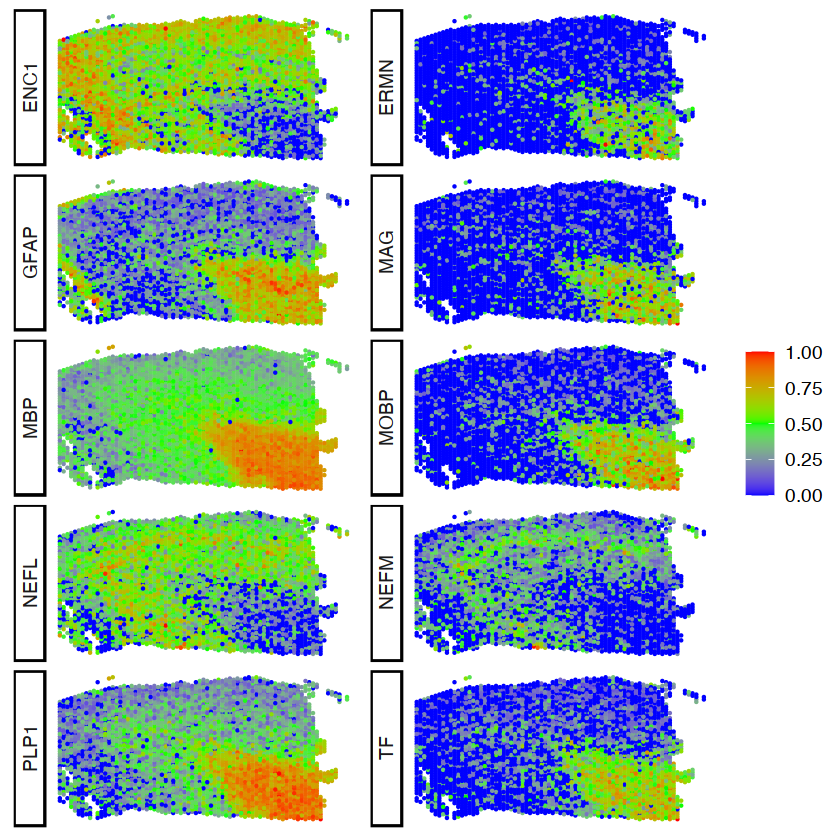

In [2]:
# annotation file for converting ENSEMBL gene ID to gene symbol
gene.anno <- read.xlsx("Human_ENSEMBL_Gene_ID_MSigDB.v7.xlsx")

spatial_score <- read.csv("spatial_score.txt", row.names = 1)

spatial_score1 <- spatial_score[order(spatial_score$spatial_score, decreasing=T), ]
spatial_score2 <- spatial_score[order(spatial_score$spatial_score, decreasing=F), ]

top_spatial_gene <- rownames(spatial_score1[1:10, ])
top_spatial_gene2 <- gene.anno[match(top_spatial_gene, gene.anno$Probe.Set.ID), "Gene.Symbol"]
top_nonspatial_gene <- rownames(spatial_score2[1:10, ])
top_nonspatial_gene2 <- gene.anno[match(top_nonspatial_gene, gene.anno$Probe.Set.ID), "Gene.Symbol"]

pos <- t(h5read("sample_151673.h5", "pos"))
pos <- data.frame(pos)
colnames(pos) <- c("x", "y")
raw.counts <- h5read("sample_151673.h5", "X")
gene <- h5read("sample_151673.h5", "gene")
cell <- h5read("sample_151673.h5", "cell")
rownames(pos) <- cell

sce <- SingleCellExperiment(list(counts=as.matrix(raw.counts)))
rownames(sce) <- gene
colnames(sce) <- cell
sce <- logNormCounts(sce, size.factors = sizeFactors(sce))
lograwcounts <- sce@assays@data$logcounts
lograwcounts <- t(apply(lograwcounts, 1, function(z) scales::rescale(z, to=c(0,1))))

spatial.gene.data <- data.frame(exp=c(lograwcounts[top_spatial_gene[1],], lograwcounts[top_spatial_gene[2],],
                                      lograwcounts[top_spatial_gene[3],], lograwcounts[top_spatial_gene[4],],
                                      lograwcounts[top_spatial_gene[5],], lograwcounts[top_spatial_gene[6],],
                                      lograwcounts[top_spatial_gene[7],], lograwcounts[top_spatial_gene[8],],
                                      lograwcounts[top_spatial_gene[9],], lograwcounts[top_spatial_gene[10],]),
                                gene=rep(top_spatial_gene2, each=nrow(pos)),
                                x=rep(pos$x, 10), y=rep(pos$y, 10))

ggplot(spatial.gene.data, aes(x=x, y=y, color=exp)) + geom_point(size=0.2) +
  facet_wrap(~gene, nrow=5, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
  theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), text = element_text(size=14))

Plot top 10 non-spatial genes. Top non-spatial genes are selected by genes with smallest spatial scores.

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”


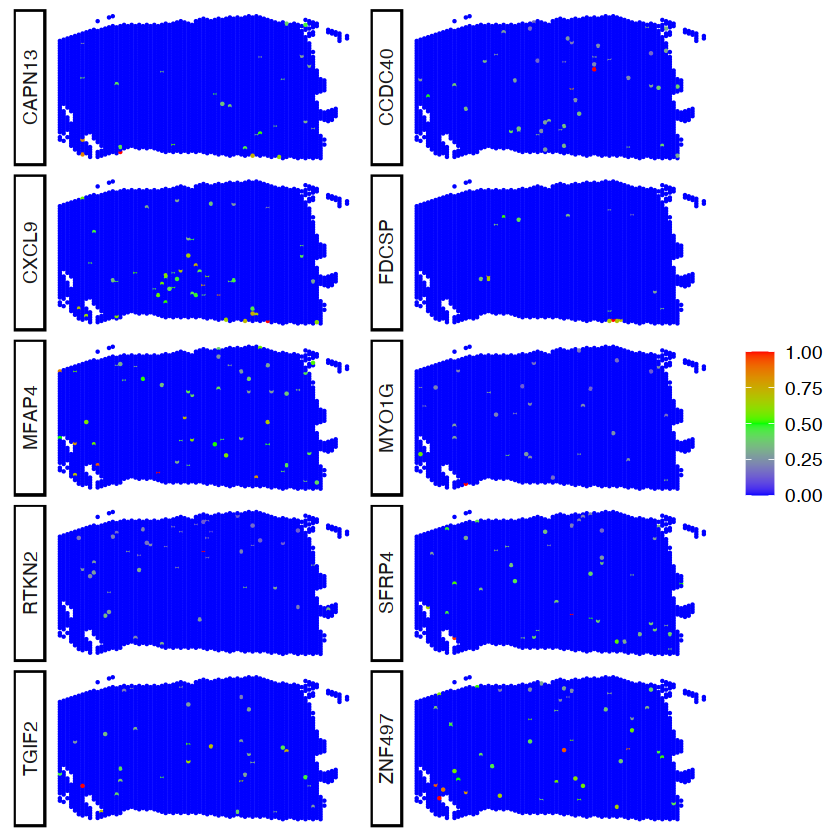

In [3]:
nonspatial.gene.data <- data.frame(exp=c(lograwcounts[top_nonspatial_gene[1],], lograwcounts[top_nonspatial_gene[2],],
                                      lograwcounts[top_nonspatial_gene[3],], lograwcounts[top_nonspatial_gene[4],],
                                      lograwcounts[top_nonspatial_gene[5],], lograwcounts[top_nonspatial_gene[6],],
                                      lograwcounts[top_nonspatial_gene[7],], lograwcounts[top_nonspatial_gene[8],],
                                      lograwcounts[top_nonspatial_gene[9],], lograwcounts[top_nonspatial_gene[10],]),
                                gene=rep(top_nonspatial_gene2, each=nrow(pos)),
                                x=rep(pos$x, 10), y=rep(pos$y, 10))

ggplot(nonspatial.gene.data, aes(x=x, y=y, color=exp)) + geom_point(size=0.2) +
  facet_wrap(~gene, nrow=5, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
  theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), text = element_text(size=14))